In [ ]:
SEED = 42

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

!cp /gdrive/MyDrive/kaggle.json /content

# Downloading the dataset
!pip install -q opendatasets

import opendatasets as od
import pandas as pd

od.download('https://www.kaggle.com/datasets/cicdataset/cicids2017/data')

Mounted at /gdrive


100%|██████████| 230M/230M [00:03<00:00, 74.6MB/s]


In [ ]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from statistics import variance

In [ ]:
path = "./cicids2017/MachineLearningCSV/MachineLearningCVE"

def getData(path, ):
  files = os.listdir(path)
  files = [f for f in files if os.path.isfile(path+'/'+f)]

  dfs = {}
  for file in files:
    dfs[file] = pd.read_csv(path+"/"+file)

  #Combine all the datasets
  df = pd.DataFrame()

  for filename,data in dfs.items():
    data["WeekDay"] = np.char.array([filename.split("-")[0]]*len(data))
    data["TimeOfDay"] = np.char.array([re.findall(r"[\w']+", filename)[2]]*len(data))
    df = pd.concat([df,data],ignore_index=True)

  df.sample(5), len(df)
  return df

df = getData(path)

In [ ]:
def clean(df):

  #Dropping unwanted rows
  tempdf = df[(df["Flow Bytes/s"] == np.inf) | (df["Flow Bytes/s"].isna())]
  tempdf = df.drop(tempdf.index)
  return tempdf

df = clean(df)

In [ ]:
df.columns

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

In [ ]:
#Convert the problem to Binary Classification
def choose(label):
  if label=='BENIGN':
    return 0
  else:
    return 1

df[' Label'] = df[' Label'].apply(choose)

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(df.drop([" Label"], axis=1), df[" Label"], test_size=0.30, random_state=SEED)

In [ ]:
VAR_THRESHOLD = 0.01

var_vals={}
for feat in Xtrain.select_dtypes(include=[np.number]).columns:
  var_vals[feat] = variance(Xtrain.loc[:, feat])

def var_filter_func(pair):
  _, val = pair
  return True if abs(val) < VAR_THRESHOLD else False

feat_to_remove = dict(filter(var_filter_func, var_vals.items()))

In [ ]:
Xtrain.drop(feat_to_remove, axis=1, inplace=True)
Xtest.drop(feat_to_remove, axis=1, inplace=True)

In [ ]:
Xtrain.drop(['WeekDay','TimeOfDay'], axis=1, inplace=True)
Xtest.drop(['WeekDay','TimeOfDay'], axis=1, inplace=True)

In [ ]:
#Scaling data

scaler = StandardScaler().fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
Xtest = scaler.transform(Xtest)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA().fit(Xtrain)
Xtrain = pca.transform(Xtrain)
Xtest = pca.transform(Xtest)

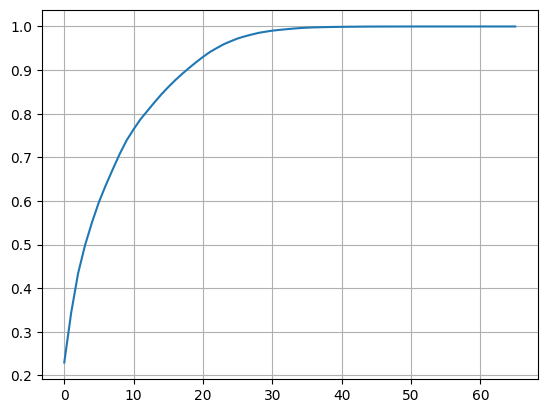

In [ ]:
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.grid()

In [ ]:
Xtrain = Xtrain[:,0:25]
Xtest = Xtest[:,0:25]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

parameters = {
    'max_depth' : [5],
    'min_samples_split' : [50000, 60000],
    'min_samples_leaf' :[10000, 15000],
    'n_estimators' : [60]
}

model=RandomForestClassifier()
clf = GridSearchCV(model, parameters, cv = 10, scoring=['accuracy','precision', 'recall','f1'], refit='f1',verbose=10)

In [ ]:
clf.fit(Xtrain, ytrain)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV 1/10; 1/4] START max_depth=5, min_samples_leaf=10000, min_samples_split=50000, n_estimators=60
[CV 1/10; 1/4] END max_depth=5, min_samples_leaf=10000, min_samples_split=50000, n_estimators=60; accuracy: (test=0.958) f1: (test=0.890) precision: (test=0.933) recall: (test=0.850) total time= 8.9min
[CV 2/10; 1/4] START max_depth=5, min_samples_leaf=10000, min_samples_split=50000, n_estimators=60
[CV 2/10; 1/4] END max_depth=5, min_samples_leaf=10000, min_samples_split=50000, n_estimators=60; accuracy: (test=0.959) f1: (test=0.890) precision: (test=0.935) recall: (test=0.849) total time= 9.7min
[CV 3/10; 1/4] START max_depth=5, min_samples_leaf=10000, min_samples_split=50000, n_estimators=60
[CV 3/10; 1/4] END max_depth=5, min_samples_leaf=10000, min_samples_split=50000, n_estimators=60; accuracy: (test=0.961) f1: (test=0.895) precision: (test=0.937) recall: (test=0.857) total time= 8.6min
[CV 4/10; 1/4] START max_depth=5, mi